In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
from agg_models.myimports  import *
from agg_models import myJupyterUtils ## Remove stacktraces on Keyboardinterupt
plt.style.use('ggplot')

# helpers to compute metrics
from agg_models.validation import MetricsComputer,  LLH  
Validation = MetricsComputer("click")

# baselines
from agg_models.basicmodels import LogisticModel, NaiveBayesModel, LogisticModelWithCF 
from agg_models.aggLogistic import AggLogistic

# loading public "criteo attribution dataset"
from agg_models import loaddata  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# code to prepare the aggregated dataset
from agg_models.featuremappings import AggDataset 

In [4]:
## Most relevant code is there:
from agg_models.agg_mrf_model import AggMRFModel
import agg_models.agg_mrf_model
# also in https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/baseaggmodel.py

## Download Data
- downloading criteo-research-attribution-dataset
- from url http://go.criteo.net

In [5]:
#loaddata.download_dataset()

## Loading data
3 versions of the dataset are used for experiments: "small" , "sampled" and "full"
- "full" has 11 features with about 16M samples
- "sampled" has the same 11 features, but only 160k samples
- "small" also has 160k samples, but only the 5 features with lowest modalities count, and allow for fast experiments.

In [6]:
dataset = "small" # fast expriments
# dataset= "sampled" # Training a MRF may require 5h and 16Go data
# dataset= "full"  # Training a MRF may require 32Go, and several days

In [7]:
train, valid, features, label = loaddata.getDataset(dataset)

Sampling ratio :0.01
Nb train samples: 115382 , Nb valid samples: 49770  
features:['cat1', 'cat4', 'cat6', 'cat8', 'cat9']


In [8]:
train.sample(2)

,cat1,cat4,cat6,cat8,cat9,click
16105981,25259032,23549932,5824235,29196072,29196072,0
10532191,30763035,29196072,1973606,23998111,16022558,0


In [9]:
for f in features:
    nbModalities = len(set(train[f].values))
    print( f"feature {f} has {nbModalities} distinct modalities" )

feature cat1 has 9 distinct modalities
feature cat4 has 14 distinct modalities
feature cat6 has 30 distinct modalities
feature cat8 has 11 distinct modalities
feature cat9 has 30 distinct modalities


## Preparing Aggregated data

- aggdata contains projections of number of displays and clicks along each pair of feature
- may also add some noise to make it differential private
- the goal is to learn a model predicting Proba( label | features) using *only* those aggdata.

In [10]:
# parameters for of the privacy protecting noise.
epsilon = None  # Set to None to get no noise.
delta = None 

In [11]:
aggdata = AggDataset( features, "*&*", train , label, epsilon, delta )

#https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/featuremappings.py#L205

In [12]:
print( f" Nb Queries: {len(aggdata.aggDisplays)}")
print( f" Noise distribution: {aggdata.noiseDistribution}" )

 Nb Queries: 15
 Noise distribution: None


In [13]:
# aggdata may be viewed as a dictionary queryname -> dataframe
aggdata_datframe_dico = aggdata.toDFs()
queries = [x for x in aggdata_datframe_dico.keys()]
print( f"list of queries {queries}" )

list of queries ['cat1', 'cat4', 'cat6', 'cat8', 'cat9', 'cat1&cat4', 'cat1&cat6', 'cat1&cat8', 'cat1&cat9', 'cat4&cat6', 'cat4&cat8', 'cat4&cat9', 'cat6&cat8', 'cat6&cat9', 'cat8&cat9']


In [14]:
# Dataframe for the query  " select 'cat1', 'cat8' , count, sum(label) group by 'cat1', 'cat8' "
aggdata_datframe_dico["cat1&cat8"].sample(3)

,cat1&cat8,cat1,cat8,c,click
68,68,8,6,1130.0,476.0
117,117,7,11,0.0,0.0
16,16,6,1,388.0,90.0


In [15]:
aggdata.aggDisplays

# Dictionary of projections 

{'cat1': Projection c on cat1(10),
 'cat4': Projection c on cat4(15),
 'cat6': Projection c on cat6(31),
 'cat8': Projection c on cat8(12),
 'cat9': Projection c on cat9(31),
 'cat1&cat4': Projection c on cat1(10)xcat4(15),
 'cat1&cat6': Projection c on cat1(10)xcat6(31),
 'cat1&cat8': Projection c on cat1(10)xcat8(12),
 'cat1&cat9': Projection c on cat1(10)xcat9(31),
 'cat4&cat6': Projection c on cat4(15)xcat6(31),
 'cat4&cat8': Projection c on cat4(15)xcat8(12),
 'cat4&cat9': Projection c on cat4(15)xcat9(31),
 'cat6&cat8': Projection c on cat6(31)xcat8(12),
 'cat6&cat9': Projection c on cat6(31)xcat9(31),
 'cat8&cat9': Projection c on cat8(12)xcat9(31)}

In [16]:
aggdata.aggDisplays["cat8&cat9"]

Projection c on cat8(12)xcat9(31)

In [17]:
aggdata.aggDisplays["cat8"].Data

# a "projection" contains counts stored in an array. 
# there is dictionary modality -> index in array

array([ 2915.,  5709.,  3805.,  4642.,  4718.,  5881.,  2796.,  6765.,
       68871.,  2519.,  6761.,     0.])

In [18]:
# dico is stored in this class:
aggdata.aggDisplays["cat8&cat9"].feature
##https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/featuremappings.py#L32

# Each modality of "cat8" found in train was assigned an id, from 0 to NbCat8-1.  
# At index NbCat8, it is the count for the modality " Not found in train".  (But maybe in valid )

cat8(12)xcat9(31)

In [19]:
df = train.sample(4).copy()
## changing initial modality by index
aggdata.aggDisplays["cat8"].feature.Map( df ) ## replacing modalities of cat8 by modalities from 1 to NbCat8
aggdata.aggDisplays["cat9"].feature.Map( df )

aggdata.aggDisplays["cat8&cat9"].feature.Map( df ) ##  cat8&cat9 = cat8 + nbCat8 * cat9    (Or is i the opposite ?)

,cat1,cat4,cat6,cat8,cat9,click,c,cat8&cat9
8959765,30763035,29196072,29196072,8,26,0,1,320
9488736,25259032,29196072,138937,8,17,0,1,212
348831,30763035,29196072,1973606,9,9,0,1,117
3106075,27093701,29196072,30763035,8,25,1,1,308


##### logistic Regression
- Using full log instead of aggdata. 
- Training with all "crossfeatures" found in agg data ( ie quadratic kernell)
- We do not expect to do better, the goal is to get similar performances

In [19]:
regulL2 = 16
logisticCfs = LogisticModelWithCF( "click" , features, "*&*"  , train ,
                                      hashspace=2**22 , lambdaL2 = regulL2  )
logisticCfs.fit( train )
print( f"Logistic(*&*), l2:{regulL2}" ,  "train",  Validation.run(logisticCfs,train) , "valid" , Validation.run(logisticCfs,valid)   )

Logistic(*&*), l2:16 train NLLH=0.0600, NMSE=0.0772   valid NLLH=0.0560, NMSE=0.0724  


##### logistic Regression from aggregated clicks and full display data (quadratic kernell)
 - same performances as "standard" logistic regression
 - but still using full display data, so not really usefull

In [20]:
    regulL2 = 16
    logisticCfs = AggLogistic(  aggdata , features, clicksCfs = "*&*" , regulL2=regulL2 )
    logisticCfs.fit( train[features] , nbIter = 200 )
    print( f"Logistic(*&*), l2:{regulL2}" ,  "train",  Validation.run(logisticCfs,train) , "valid" , Validation.run(logisticCfs,valid)   )

Logistic(*&*), l2:16 train NLLH=0.0602, NMSE=0.0774   valid NLLH=0.0561, NMSE=0.0725  


##### Proposed MRF model
- uses only aggregated data
- almost retrieves logitic performances

In [20]:
regulL2 = 16
nbSamples = 10000
nbIter = 50

self = AggMRFModel( aggdata,
                    features , 
                    exactComputation=False ,  ## Using Gibbs Sampling.  actualy exact=True is broken in latest code
                    clicksCfs = "*&*", ## crossfeatures used by P(Y|X) part of the model
                    displaysCfs="*&*", ## crossfeatures used by P(X) part of the model. Here, all pairs + all single .
                    nbSamples = nbSamples, ## Nb Gibbs samples to estimate gradient
                    regulL2=1.0 ,  ## parmeter "lambda_2"
                    regulL2Click = regulL2  ## parmeter "lambda_1" 
                  )

In [21]:
self.fit(nbIter)
print( f"MRF lambda1= {regulL2}",  "train",   Validation.run(self,train) , "valid" , Validation.run(self,valid)   )

llh:2.0E+01 a:1.4E-01(0), n:50, g:6.0E+03  --
MRF lambda1= 16 train NLLH=0.0577, NMSE=0.0742   valid NLLH=0.0538, NMSE=0.0695  


In [23]:
# all parameters mu and theta concatenated in a  single vector
self.parameters

# This vector is the concatenation of parameters for associated to each projection

array([-2.21180802, -2.58310572, -4.04074273, ...,  0.        ,
        0.        ,  0.        ])

In [24]:
# List of features and crossfeatures for mu
self.displayWeights

{'cat1': WeightsSet on cat1(10) offset=0,
 'cat4': WeightsSet on cat4(15) offset=10,
 'cat6': WeightsSet on cat6(31) offset=25,
 'cat8': WeightsSet on cat8(12) offset=56,
 'cat9': WeightsSet on cat9(31) offset=68,
 'cat1&cat4': WeightsSet on cat1(10)xcat4(15) offset=99,
 'cat1&cat6': WeightsSet on cat1(10)xcat6(31) offset=249,
 'cat1&cat8': WeightsSet on cat1(10)xcat8(12) offset=559,
 'cat1&cat9': WeightsSet on cat1(10)xcat9(31) offset=679,
 'cat4&cat6': WeightsSet on cat4(15)xcat6(31) offset=989,
 'cat4&cat8': WeightsSet on cat4(15)xcat8(12) offset=1454,
 'cat4&cat9': WeightsSet on cat4(15)xcat9(31) offset=1634,
 'cat6&cat8': WeightsSet on cat6(31)xcat8(12) offset=2099,
 'cat6&cat9': WeightsSet on cat6(31)xcat9(31) offset=2471,
 'cat8&cat9': WeightsSet on cat8(12)xcat9(31) offset=3432}

In [25]:
# List of features and cfs for theta
self.clickWeights
# class WeightsSet : https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/baseaggmodel.py#L8

## In parameter vector, indices from 3719 to 3729 are the parameters "theta" 
##   associated to values of the single feature "cat1"

{'cat1': WeightsSet on cat1(10) offset=3804,
 'cat4': WeightsSet on cat4(15) offset=3814,
 'cat6': WeightsSet on cat6(31) offset=3829,
 'cat8': WeightsSet on cat8(12) offset=3860,
 'cat9': WeightsSet on cat9(31) offset=3872,
 'cat1&cat4': WeightsSet on cat1(10)xcat4(15) offset=3903,
 'cat1&cat6': WeightsSet on cat1(10)xcat6(31) offset=4053,
 'cat1&cat8': WeightsSet on cat1(10)xcat8(12) offset=4363,
 'cat1&cat9': WeightsSet on cat1(10)xcat9(31) offset=4483,
 'cat4&cat6': WeightsSet on cat4(15)xcat6(31) offset=4793,
 'cat4&cat8': WeightsSet on cat4(15)xcat8(12) offset=5258,
 'cat4&cat9': WeightsSet on cat4(15)xcat9(31) offset=5438,
 'cat6&cat8': WeightsSet on cat6(31)xcat8(12) offset=5903,
 'cat6&cat9': WeightsSet on cat6(31)xcat9(31) offset=6275,
 'cat8&cat9': WeightsSet on cat8(12)xcat9(31) offset=7236}

In [41]:
# there are also two 'intercept' parameters:
self.muIntercept, self.lambdaIntercept
#  ...  thus P(Y = 1 |X =x) = sigmoid( K(x) . self.parameters[someOffset:] +  self.lambdaIntercept )

#  todo:  remane self.lambdaIntercept to self.thetaIntercept to get coherent notations

(11.208137924615508, -0.5709612362064984)

In [42]:
## samples of "X"

self.samples.data.shape

(5, 50000)

In [43]:
## Computing dotproducts between K(x) and mu or theta:

## https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/baseaggmodel.py#L62

mus    = self.dotproducts( self.displayWeights, self.samples.data ) + self.muIntercept
mus

## https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/agg_mrf_model.py#L145

## note: I just added some comments in the code, translating all the line numbers ...

array([ 7.27186429,  4.14907328, -0.10190555, ...,  6.66457175,
        5.84908761,  5.34488567])

In [44]:
d = self.Data
d
#  vector with  the counts of click or display  from aggregated data.
# Same indexing as self.parameters

array([12646.,  8991.,  2355., ...,     0.,     0.,     0.])

In [45]:
p = self.getPredictionsVector( self.samples )
p
# expected counts according to the model, computed by MC on the samples 

array([12862.89684,  9498.32856,  2236.12254, ...,     0.     ,
           0.     ,     0.     ])

In [46]:
## https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/agg_mrf_model.py#L187
w = self.displayWeights["cat1"]
w.feature.Project_(  self.samples.data  , self.samples.pdisplays ) # Correct for grads

# a bit uselessly complicated :  self.samples.pdisplays  is constant
# This allows having samples with different 'weights', for example one sample for each possible modality of X

array([12862.89684   ,  9498.32856   ,  2236.12254   ,  4398.39996   ,
        3796.1007    , 10019.85972   ,  8665.2633    , 13003.6641    ,
       50902.36427998,     0.        ])

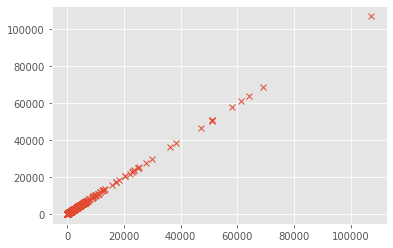

In [47]:
# After fiting the model,  "data" and "prediction" should be equal
plt.plot( d,p, "x" )


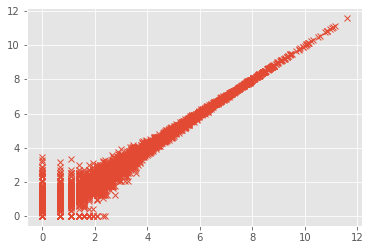

In [48]:
# ... up to the noise of the sampling / convergence of optimizer
plt.plot( np.log (1+d), np.log( 1+p), "x" )

In [50]:
## gradient is equal to d-p  + gradient (regularization)
g = self.computeGradient()

# https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/agg_mrf_model.py#L228

In [51]:
self.initParameters()
# https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/agg_mrf_model.py#L90
##  inital values of mu, theta such that:
##  -  P(Y=1|X) 1s flat nd equal to P(Y=1)   (ie all weights = 0 except intercept)
##  -  for each coordinate Xk of X,  P( Xk ) is correct, and Xk indepedent from Xk'
##     ( => set weights of crossfeatures to 0  
##        and initialize weights of single features to log( P_train( Xk =xk ) )

In [52]:
self.samples

## https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/SampleSet.py

In [53]:
self.samples.data.shape

(5, 50000)

In [54]:
self.samples.Df().sample(3)

,cat1,cat4,cat6,cat8,cat9
32053,0,11,1,8,26
25076,8,11,1,1,25
45602,1,11,16,8,25


In [55]:
## fitting the model.  Sligtly simplified (no line search)

# intialiaze
self = AggMRFModel( aggdata,
                    features , 
                    exactComputation=False ,  ## Using Gibbs Sampling.  actualy exact=True is broken in latest code
                    clicksCfs = "*&*", ## crossfeatures used by P(Y|X) part of the model
                    displaysCfs="*&*", ## crossfeatures used by P(X) part of the model. Here, all pairs + all single .
                    nbSamples = nbSamples, ## Nb Gibbs samples to estimate gradient
                    regulL2=1.0 ,  ## parmeter "lambda_2"
                    regulL2Click = regulL2  ## parmeter "lambda_1" 
                  )

## predicting constant CTR => normalize LLH on train  = 0.0 
print( f"MRF lambda1= {regulL2}",  "train",   Validation.run(self,train) , "valid" , Validation.run(self,valid)   )

alpha = 0.05
for i in range(0,50):
    g = self.computeGradient()
    precondG = g / (self.Data+10)  #  diagonal Hessian at origin = self.Data + regul
    self.parameters -= alpha * precondG
    self.update()  ## 
    self.updateSamplesWithGibbs( self.samples , nbsteps=1 )
print( f"MRF lambda1= {regulL2}",  "train",   Validation.run(self,train) , "valid" , Validation.run(self,valid)   )

MRF lambda1= 16 train NLLH=-0.0000, NMSE=-0.0000   valid NLLH=-0.0000, NMSE=-0.0000  
MRF lambda1= 16 train NLLH=0.0591, NMSE=0.0763   valid NLLH=0.0549, NMSE=0.0709  


In [56]:
## fitting the model.  Sligtly simplified (no line search)

# intialiaze
self = AggMRFModel( aggdata,
                    features , 
                    exactComputation=False ,  ## Using Gibbs Sampling.  actualy exact=True is broken in latest code
                    clicksCfs = "*&*", ## crossfeatures used by P(Y|X) part of the model
                    displaysCfs="*&*", ## crossfeatures used by P(X) part of the model. Here, all pairs + all single .
                    nbSamples = nbSamples, ## Nb Gibbs samples to estimate gradient
                    regulL2=1.0 ,  ## parmeter "lambda_2"
                    regulL2Click = regulL2  ## parmeter "lambda_1" 
                  )


In [102]:
## gibbs sampling
self.updateSamplesWithGibbs( self.samples , nbsteps=1 )

##https://gitlab.criteois.com/a.gilotte/aggdata/-/blob/master/src/agg_mrf_model.py#L178

## Internal implem of Gibbs sampler

code below is mostly copy-pasted from agg_mrf_model.fastGibbsSample (adapting a few var names) to allow to unroll the loops and see what the variables contain.

Having to use only numpy to get it fast, and ugly because of that.
(And there is a bug. Can you understand what this version of the code does ? )

In [55]:
rows = self.samples.data[:,:1000].transpose()
rows.shape

y =self.samples.y[ :1000 ]
# 1000 samples of X

In [10]:
## extracting all relavant data of the model to run Gibbs sampling.
## and exporting it to numpy arrays. ()
exportedDisplayWeights, exportedClickWeights, modalitiesByVarId, paramsVector = self.exportWeightsAll()


NameError: name 'self' is not defined

In [90]:
#  running one step of Gibbs on those samples
print( rows[1] )
agg_mrf_model.fastGibbsSample(exportedDisplayWeights, exportedClickWeights, modalitiesByVarId, paramsVector,
                                 rows , 1, y )
print( rows[1] )

# function "fastGibbsSample" is not on a class and takes as input the model in np.array format
# This allows to run sampling in parallel with joblib 

[ 8 11 23  8 25]
[ 8 11 29  8 17]


In [59]:
    ## Internal implem of Gibbs sampling
    # copy-pasted from agg_mrf_model.fastGibbsSample

    
    ## data describing the crossfeatures
    allcoefsv,allcoefsv2, alloffsets, allotherfeatureid = exportedDisplayWeights
    click_allcoefsv,click_allcoefsv2, click_alloffsets, click_allotherfeatureid = exportedClickWeights
    
    x =rows.transpose()
    nbsamples =x.shape[1]


In [60]:
self.features[3]

'cat8'

In [61]:
            # For each feature, ressample this feature conditionally to the other 
            #for varId in f:   
            varId = 3 #  let us just fix one feature here   #  resampling self.features[1] -> "cat4"
    
    
    
            ## data describing the different crossfeatures involving varId  in " K(x).mu" 
            ## Those things are arrays, of len the number of crossfeatures involving varId.
            disp_coefsv = allcoefsv[ varId ] 
            disp_coefsv2 = allcoefsv2[ varId ]
            disp_offsets = alloffsets[ varId ]
            disp_otherfeatureid = allotherfeatureid[ varId ]

            ## idem, but crossfeatures in " K(x).theta" part of the model 
            click_coefsv = click_allcoefsv[ varId ]
            click_coefsv2 = click_allcoefsv2[ varId ]
            click_offsets = click_alloffsets[ varId ]
            click_otherfeatureid = click_allotherfeatureid[ varId ]

            # array of possible modalities of varId 
            modalities = modalitiesByVarId[varId]  ## Should be 0,1,2 ... NbModalities
            ## for each modality, compute P( modality | other features ) as exp( dotproduct)
            ## initializing dotproduct
            mus = np.zeros(( nbsamples , len(modalities)))
            lambdas = np.zeros(( nbsamples , len(modalities)))


In [62]:
                ## Computing the dotproducts    
                #  For each crossfeature containing varId
                #for varJ in np.arange( 0, len(disp_coefsv) ):

                varJ = 1
                # let m a modality of feature varId, and m' a modality of the other feature
                #  Value of the crossfeature is " m *  disp_coefsv[varJ] + m' * disp_coefsv2[varJ]  " 
                # values of m' in the data
                modsJ = x[ disp_otherfeatureid[varJ] ] * disp_coefsv2[varJ] 
                # all possible modality m
                mods = modalities * disp_coefsv[varJ] 
                # Computing crossfeatures
                ## this is a matrix of shape (nbSamples, nbModalities of varId)
                crossmods = np.add.outer(modsJ , mods) + disp_offsets[varJ]  
                # Adding crossfeature weight.
                mus += paramsVector[crossmods]


In [49]:
print(crossmods.shape)
crossmods

(1000, 11)


array([[556, 566, 576, ..., 636, 646, 656],
       [556, 566, 576, ..., 636, 646, 656],
       [555, 565, 575, ..., 635, 645, 655],
       ...,
       [556, 566, 576, ..., 636, 646, 656],
       [548, 558, 568, ..., 628, 638, 648],
       [552, 562, 572, ..., 632, 642, 652]])

In [63]:
            mus = np.exp(mus)
            lambdas = np.exp(lambdas)



array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [77]:
.shape

(1, 1000)

In [ ]:
len(self.samples.y)